# IEA 15MW Reference Turbine check-out/calibration notebook (ALM+OpenFAST)

Use this notebook to set up a series of runs for turbine calibration and check-out

In [1]:
%%capture 

# Important header information
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import matplotlib.pyplot    as plt
import amrwind_frontend as amrwind
import tempfile
import shutil
# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

**Note**: Make sure there is a turbine file which looks like:

In [2]:
with open(amrwindfedirs[1]+"/turbines/IEA15MW.yaml")as f: print(f.read())

turbines:
  IEA15MW_Joukowski:     # This is an arbitrary, unique name
    turbinetype_name:    "IEA15MW_Joukowsky"
    turbinetype_comment: "Dummy layout"   # arbitrary
    Actuator_type:                JoukowskyDisk
    Actuator_rotor_diameter:      240
    Actuator_hub_height:          150     # Double-check
    Actuator_output_frequency:    10                   
    # --------------------
    Actuator_diameters_to_sample: 2.5     # How far upstream to sample inflow wind
    #Actuator_epsilon:             [5.0]   # Epsilon in Z (might need to play with this guy)
    Actuator_num_points_r:        40      # number of radial (might need to play with this guy)
    Actuator_num_points_t:        5       # number of pts in theta (might need to play with this guy)
    #Actuator_vortex_core_size:    24.0    # might need to play with this
    # --------------------
    # These will come from
    # https://github.com/IEAWindTask37/IEA-15-240-RWT/blob/master/performance/performance_ccblade.dat


Note that both `Actuator_epsilon` and `Actuator_epsilon_tower` are commented out.  We can set those values later.

In [3]:
# Start the amrwind_frontend app 
case = amrwind.MyApp.init_nogui()

In [4]:
curdir=os.getcwd()

# Create a temporary working directory and switch to it

# Uncomment these lines to make your own tempdir
## tempdir = 'tempturbinedir'
## os.mkdir(tempdir)
# Otherwise use a system temporary directory
tempdir = tempfile.mkdtemp(prefix='tempturbine-')
os.chdir(tempdir)
print('Using temporary directory: '+tempdir)

Using temporary directory: /tmp/tempturbine-x07sqbys


## Set up the basic simulation properties

In [5]:
rhodensity = 1.225
WS         = 9.0                                     # This is temporary, we will vary across a range below
eps        = 5.0
case.setAMRWindInput('useWSDir', True)
case.setAMRWindInput('ABL_windspeed', WS, forcechange=True)
case.setAMRWindInput('ABL_winddir', 270,  forcechange=True)
case.ABL_calculateWindVector()

In [6]:
case.setAMRWindInput('time_control',   ['const dt'])
case.setAMRWindInput('time.stop_time', 360)
case.setAMRWindInput('time.fixed_dt',  0.02)
case.setAMRWindInput('time.checkpoint_interval',  1000)
case.setAMRWindInput('incflo.physics', ['FreeStream', 'Actuator'])

In [7]:
case.setAMRWindInput('ConstValue.density.value',  rhodensity)
case.setAMRWindInput('incflo.density',            rhodensity)
case.setAMRWindInput('incflo.velocity',           [WS, 0.0, 0.0])
case.setAMRWindInput('ConstValue.velocity.value', [WS, 0.0, 0.0])
case.setAMRWindInput('turbulence.model',          ['Laminar'])

## Set the BC's

In [8]:
case.setAMRWindInput('is_periodicx', False)
case.setAMRWindInput('is_periodicy', True)
case.setAMRWindInput('is_periodicz', True)  

case.setAMRWindInput('xlo.type', 'mass_inflow')
case.setAMRWindInput('xhi.type', 'pressure_outflow')
case.setAMRWindInput('xlo.density',  rhodensity)
case.setAMRWindInput('xlo.velocity', [WS, 0.0, 0.0])

In [9]:
# Add the turbine specifications flag
## Note that the options field can have things like:
##    ADparam_TwrAero:False ADparam_TwrShadow:0 FSTparam_TMax:181234.0
OFoptions=("ADparam_TwrAero:True ADparam_TwrShadow:0 FSTparam_CompHydro:0 FSTparam_CompSub:0 "
           "EDparam_YawDOF:False "
           "EDparam_PtfmSgDOF:False "
           "EDparam_PtfmSwDOF:False "
           "EDparam_PtfmHvDOF:False "
           "EDparam_PtfmRDOF:False "
           "EDparam_PtfmPDOF:False "
           "EDparam_PtfmYDOF:False "           
          )

#"EDparam_RotSpeed:5.00 "

## To specify changes to the OpenFAST model
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T0,     0, 0, IEA15MW_ALM, 270.0, 0.0, {OFoptions}
""".format(OFoptions=OFoptions)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [10]:
case.setAMRWindInput('turbines_domainsize', [2560.0*2, 960.0*2, 960.0*2])
case.setAMRWindInput('turbines_backgroundmeshsize', 20.0)
case.setAMRWindInput('turbines_deleteprev', True)
case.setAMRWindInput('turbines_freespace', True)   # Make this have no ground
#case.setAMRWindInput('zlo_type', 'slip_wall')
#case.setAMRWindInput('zhi_type', 'slip_wall')

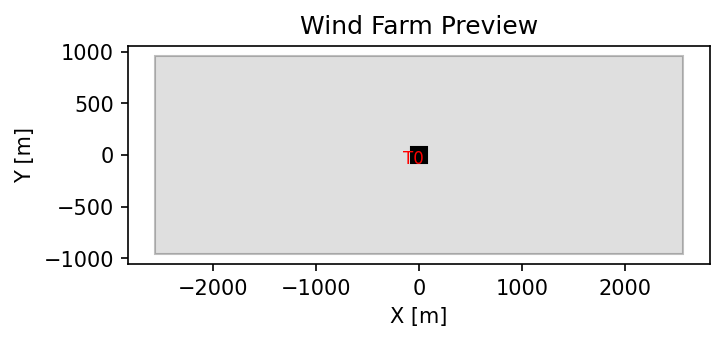

In [11]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(5,5), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

In [12]:
# Now create the turbines
case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/ALCC_Frontier_WindFarm/turbines/turbinedef/OpenFAST3p4_IEA15MW to T0_OpenFAST3p4_IEA15MW
T0_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0)])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
['T0']


         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED]
     False PtfmPDOF - Platform pitch tilt rotation DOF (flag) [EDITED]
     False PtfmYDOF - Platform yaw rotation DOF (flag) [EDITED]


In [13]:
# Set some globals
case.setAMRWindInput('Actuator_default_type', ['TurbineFastLine'])
case.setAMRWindInput('Actuator_TurbineFastLine_density',       rhodensity,      forcechange=True)
case.setAMRWindInput('Actuator_TurbineFastLine_epsilon',       [eps, eps, eps], forcechange=True)  # You can change this
case.setAMRWindInput('Actuator_TurbineFastLine_epsilon_tower', [eps, eps, eps], forcechange=True)  # You can change this

In [14]:
#case.extradictparams['Actuator.sample_vel_nmhalf'] = True

## Add turbine refinement

In [15]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     10,       10,         3,       2,     2,     center:farm
1,     2.5,      2.5,        2.5,     1.2,   1.2,   center:farm
2,     1.0,      1.0,        1.00,    1.0,   1.0,  
#3,     0.20,     0.20,       0.75,    0.75,  0.75,  
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [16]:
case.refine_createAllZones()
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxtagging'].getitemlist())

['Farm_level_0_zone', 'Farm_level_1_zone', 'T0_level_2_zone']


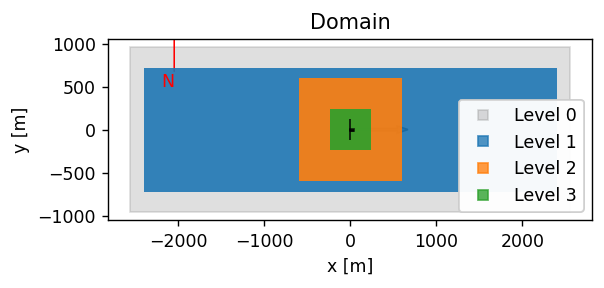

In [17]:
# Plot the domain
fig, ax2 = plt.subplots(figsize=(5,5), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.plotDomain(ax=ax2)

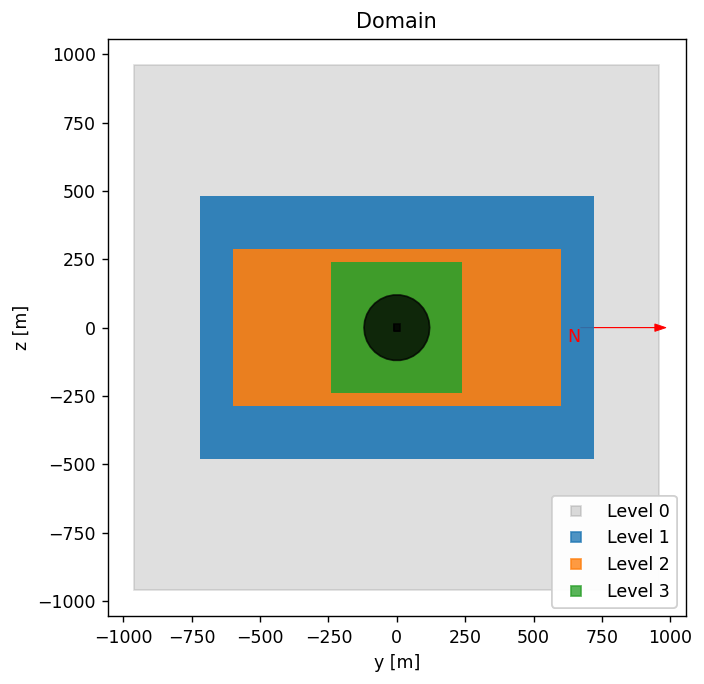

In [18]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'YZ'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

In [19]:
case.estimateMeshSize()

Refinement Farm_level_0_zone: level 1: 6635520 cells
Refinement Farm_level_1_zone: level 2: 6635520 cells
Refinement T0_level_2_zone: level 3: 7077888 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0      2359296             20.0 x 20.0 x 20.0
       1      6635520             10.0 x 10.0 x 10.0
       2      6635520                5.0 x 5.0 x 5.0
       3      7077888                2.5 x 2.5 x 2.5
  TOTAL:     22708224


### Create sampling planes

In [20]:
samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
#cl1, centerline, 1,  0, none, none,  none,  11, 11, none
#rp1, rotorplane, 2,  0, none, none,  none,  11, 11, none
#sw1, streamwise, 2,  1, 1, 0.5,  0.5,  11, 11, usedx:0.25 noffsets:1
hh,  hubheight,2560,2560,960, 0,  none,  11, 11, usedx:10 units:meter center:farm orientation:x
"""
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', True)

In [21]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['Farm_hh']


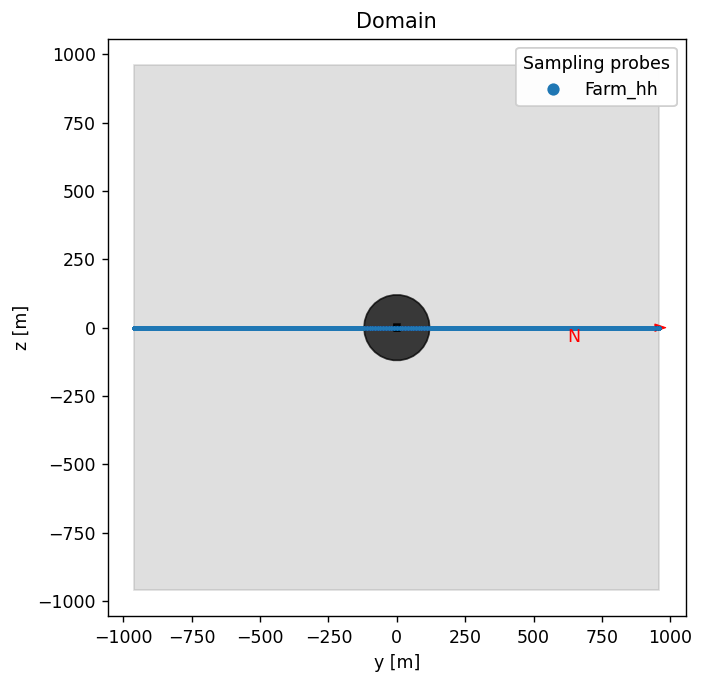

In [22]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

In [23]:
print(case.writeAMRWindInput(''))

# --- Simulation time control parameters ---
time.stop_time                           = 360.0               # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.02                # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 1000                
incflo.physics                           = FreeStream Actuator # List of physics models to include in simulation.
incflo.verbose                           = 0                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = Laminar             
incflo.gravity                           = 0.0 0.0 -9.81       # Gravitational acceleration vector (x,y,z) [m/s^2]
incflo.density                           = 1

In [24]:
# Clean up the temporary directory
docleanup = True
os.chdir(curdir)
if docleanup:
    try:
        shutil.rmtree(tempdir)
    except:
        print("Error cleaning up: "+tempdir)

## Set up a wind sweep

In [25]:
# Set the parameters
case.setAMRWindInput('sweep_windspeeds', '7 9 10 11')
case.setAMRWindInput('sweep_winddirs',   '270')
case.setAMRWindInput('sweep_caseprefix', 'Calibrate_dx2p50_A{CASENUM}_EPS%0.2f_WS_{WS}'%eps)
case.setAMRWindInput('sweep_dirprefix',  'Calibrate_dx2p50_A{CASENUM}_EPS%0.2f_WS_{WS}'%eps)
case.setAMRWindInput('sweep_usenewdirs', True)
case.setAMRWindInput('sweep_logfile',    'RunCalibration_dx2p50_A_Eps%0.2f_logfile.yaml'%eps)

In [26]:
# Submission parameters
case.popup_storteddata['submitscript']['submitscript_numnodes'] = 8
case.popup_storteddata['submitscript']['submitscript_runtime']  = '4:00:00'
case.popup_storteddata['submitscript']['submitscript_wcid']     = 'fy210193'
case.popup_storteddata['submitscript']['submitscript_partition']= 'short,batch'
case.popup_storteddata['submitscript']['submitscript_corespernode'] = 36
case.popup_storteddata['submitscript']['submitscript_queue']    = 'normal'
case.popup_storteddata['submitscript']['submitscript_jobname']  = 'IEA15MW'
case.popup_storteddata['submitscript']['submitscript_exe']      = '/projects/wind_uq/lcheung/AMRWindBuilds/hfm.20230731/amr-wind/build/amr_wind'

case.setAMRWindInput('sweep_createsubmitscript', False)
case.setAMRWindInput('sweep_submitjob',          False)

In [27]:
# Set up the cases
case.sweep_SetupRunParamSweep(verbose=True)

       NUM           WS         WDir            Case name
       ---           --         ----            ---------
         0      7.00000    270.00000 Calibrate_dx2p50_A0_EPS5.00_WS_7.0
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/ALCC_Frontier_WindFarm/turbines/turbinedef/OpenFAST3p4_IEA15MW to T0_OpenFAST3p4_IEA15MW
T0_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0)])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])


         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED]
     False PtfmPDOF - Platform pitch tilt rotation DOF (flag) [EDITED]
     False PtfmYDOF - Platform yaw rotation DOF (flag) [EDITED]


         1      9.00000    270.00000 Calibrate_dx2p50_A1_EPS5.00_WS_9.0
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/ALCC_Frontier_WindFarm/turbines/turbinedef/OpenFAST3p4_IEA15MW to T0_OpenFAST3p4_IEA15MW
T0_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0)])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
         2     10.00000    270.00000 Calibrate_dx2p50_A2_EPS5.00_WS_10.0


         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED]
     False PtfmPDOF - Platform pitch tilt rotation DOF (flag) [EDITED]
     False PtfmYDOF - Platform yaw rotation DOF (flag) [EDITED]


docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/ALCC_Frontier_WindFarm/turbines/turbinedef/OpenFAST3p4_IEA15MW to T0_OpenFAST3p4_IEA15MW
T0_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0)])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])
         3     11.00000    270.00000 Calibrate_dx2p50_A3_EPS5.00_WS_11.0
docopy = True from /autofs/nccs-svm1_proj/cfd162/lcheung/ALCC_Frontier_WindFarm/turbines/turbinedef/OpenFAST3p4_IEA15MW to T0_OpenFAST3p4_IEA15MW


         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED]
     False PtfmPDOF - Platform pitch tilt rotation DOF (flag) [EDITED]
     False PtfmYDOF - Platform yaw rotation DOF (flag) [EDITED]


T0_OpenFAST3p4_IEA15MW/IEA-15-240-RWT-Monopile/IEA-15-240-RWT-Monopile.fst
OrderedDict([('CompHydro', 0), ('CompSub', 0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 0)])
OrderedDict([('YawDOF', 'False'), ('PtfmSgDOF', 'False'), ('PtfmSwDOF', 'False'), ('PtfmHvDOF', 'False'), ('PtfmRDOF', 'False'), ('PtfmPDOF', 'False'), ('PtfmYDOF', 'False')])


         0 CompHydro - Compute hydrodynamic loads (switch) {0=None 1=HydroDyn} [EDITED]
         0 CompSub - Compute sub-structural dynamics (switch) {0=None 1=SubDyn 2=External Platform MCKF} [EDITED]
         0 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
     False PtfmSgDOF - Platform horizontal surge translation DOF (flag) [EDITED]
     False PtfmSwDOF - Platform horizontal sway translation DOF (flag) [EDITED]
     False PtfmHvDOF - Platform vertical heave translation DOF (flag) [EDITED]
     False PtfmRDOF - Platform roll tilt rotation DOF (flag) [EDITED]
     False PtfmPDOF - Platform pitch tilt rotation DOF (flag) [EDITED]
     False PtfmYDOF - Platform yaw rotation DOF (flag) [EDITED]


### Save the calibration

In [28]:
# Save the wind farm setup
case.setAMRWindInput('farm_usercomments', 'Test calibration process.')
case.writeFarmSetupYAML('TurbineCalibrateIEA15MW_dx2p50_A_Eps%0.2f.yaml'%eps)

Saved farm setup to TurbineCalibrateIEA15MW_dx2p50_A_Eps5.00.yaml
